In [49]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d

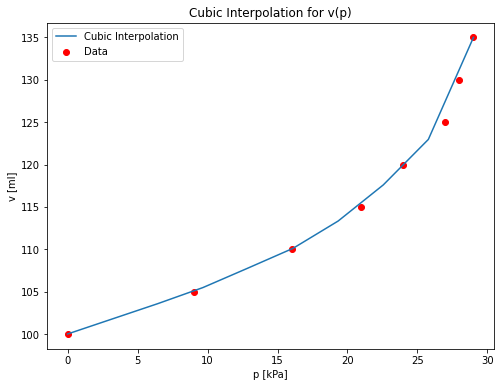

105.71428571428572


In [50]:
# Fit PV curve

# Data from Shibo groupmeeting slides pneunet actuator with h = \inf 
v_fit = np.array([0, 5, 10, 15, 20, 25, 30, 35])*1e-6+100e-6 #[m3] data in mL converted to L
p_fit = np.array([0, 9, 16, 21, 24, 27, 28, 29])*1000 #[pa] data in kpa converted to pa

# Create cubic spline
volume_act = interp1d(p_fit, v_fit, kind='slinear',bounds_error=False, fill_value="extrapolate") #L/Pa

# Plot
p_vals = np.linspace(p_fit[0], p_fit[-1], 10)
v_vals = volume_act(p_vals)

plt.figure(figsize=(8, 6))
plt.plot(p_vals/1000, v_vals*1e6, label='Cubic Interpolation')
plt.scatter(p_fit/1000, v_fit*1e6, color='red', label='Data')
plt.legend()
plt.xlabel('p [kPa]')
plt.ylabel('v [ml]')
plt.title('Cubic Interpolation for v(p)')
plt.show()

p = 10e3  # For example
v = volume_act(p)
print(v*1e6)

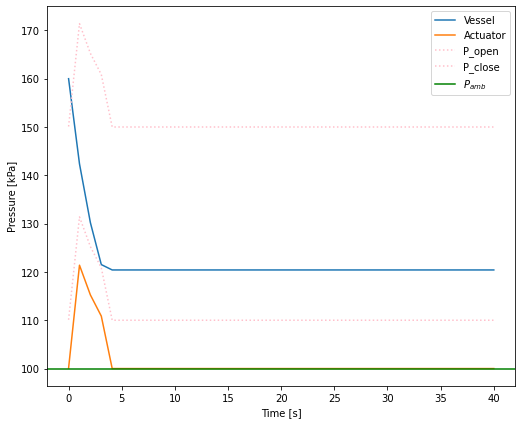

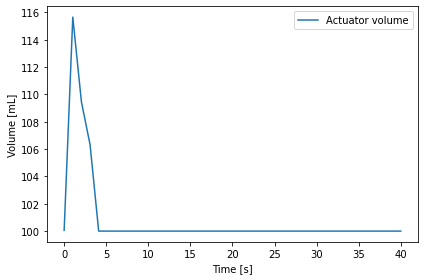

In [84]:
P_tank_0 = 1.6e5  # Initial pressure in first tank, Pa

#P_act_0 must be a fraction higher than P_amb otherwise )_act-P_amb =0 and the solver cannot devide by 0. 
P_act_0 = 1.001e5  # Initial pressure in second tank (ambient pressure), Pa
V_tank = 0.003  # Volume of first tank, m^3
V_act = 0.0003  # Volume of second tank, m^3
P_amb = 1e5  # Ambient pressure, Pa
R_valve = 500  # Resistance of first valve, Pa.s/m^3
R_act = 500# Resistance of second valve, Pa.s/m^3
P_open = 0.5e5 #pa
P_close = 0.1e5 #pa
state_v=0 #Valve normally closed 

# System of ODEs
def dPdt(P, t):
    global state_v
    P_tank, P_act = P

    Q_tank=0
    dP_tank_dt=0
    #Volume flow out of tank is pressure difference devided by the resistance of the valve 
    if state_v==1:
        if P_tank < P_act+P_close:
            state_v=0
        else:
            Q_tank += (P_tank - P_act) / R_valve if P_tank > P_act else 0  # Flow rate from tank to actuator
            dP_tank_dt += -Q_tank / V_tank
    else:
        if P_tank>P_act+P_open:
            state_v=1 
        

    Q_act = (P_act - P_amb) / R_act #if P_act > P_amb else 0  # Flow rate from second tank to environment
    

    #Flow out of the actuator is independent of state of the valve
    if P_act - P_amb>1e-3:
        dP_act_dt = ((Q_tank - Q_act) / volume_act(P_act-P_amb))  # Change in pressure in act
    elif P_act-P_amb < -1e-3:
        dP_act_dt = ((Q_act) / volume_act(0)) 
    else:
        dP_act_dt = 0

    
    
    return [dP_tank_dt, dP_act_dt]

# Time array for simulation
t = np.linspace(0, 40,40 )  # From 0 to 20 seconds, 1000 points in time

# Solve system of ODEs
P_tank, P_act = odeint(dPdt, [P_tank_0, P_act_0], t).T

# Calculate flow rates Q1 and Q2
Q_tank = np.maximum((P_tank - P_act) / R_valve, 0)
Q_act = np.maximum((P_act - P_amb) / R_act, 0)

plt.figure(figsize=(14, 6))

plt.subplot(121)  # The first plot in a 1-row, 2-column configuration
plt.plot(t, P_tank / 1e3, label='Vessel')  # Pressure in first tank, bar
plt.plot(t, P_act / 1e3, label='Actuator')  # Pressure in second tank, bar
plt.plot(t,(P_act+P_open)/1e3, label='P_open',linestyle=':',color='pink')
plt.plot(t,(P_act+P_close)/1e3, label='P_close', linestyle=':',color='pink')
plt.axhline(P_amb/1e3,label='$P_{amb}$',color='green')
plt.xlabel('Time [s]')
#plt.ylim(0, 2)
plt.ylabel('Pressure [kPa]')
plt.legend()

"""
plt.subplot(122)  # The second plot in a 1-row, 2-column configuration
plt.plot(t, Q_tank*60 , label='Vessel')
plt.plot(t, Q_act*60 , label='Actuator')  # Flow rate from second tank, L/s
plt.xlabel('Time [s]')
plt.ylabel('Flow rate [L/min]')
#plt.ylim(0, 10)
plt.legend()
"""
plt.tight_layout()
plt.show()

plt.plot(t, volume_act(P_act-P_amb)*1e6, label='Actuator volume')  # Volume of actuator, converted to mL
plt.xlabel('Time [s]')
plt.ylabel('Volume [mL]')
#plt.ylim(0,0.5)
plt.legend()

plt.tight_layout()
plt.show()

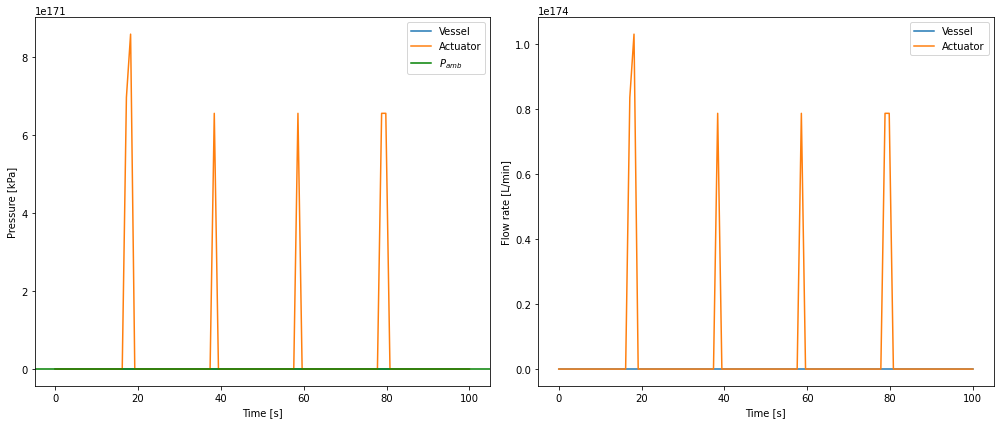

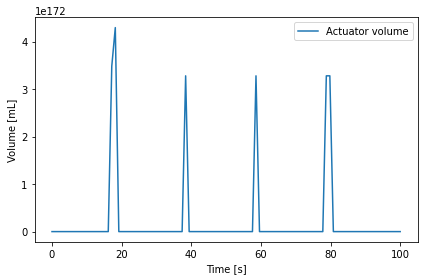